# Initial try of XGBoost

# Setup

In [12]:
import pandas as pd
import os
import numpy as np
import datetime
#import duckdb
from plotnine import *
pd.set_option("display.max_rows", 20)

In [13]:
filename = os.getcwd() + "/train.csv"
data = pd.read_csv(filename)

In [14]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
target = 'Survived'
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

1. Split data into train, test and validation
1. One hot encode categorical variables
1. Scale numerical variables
1. Impute missing age values?

In [16]:
from sklearn import metrics

def model_diagnostics(y_test, preds, preds_binary):
    dict_scores = {}

    dict_scores['accuracy'] = metrics.accuracy_score(y_test, preds_binary)
    dict_scores['average_precision'] = metrics.average_precision_score(y_true = y_test, y_score = preds)
    dict_scores['f1_score'] = metrics.f1_score(y_test, preds_binary)

    dict_scores

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, preds_binary)
    cm_display = metrics.ConfusionMatrixDisplay(cm)

    # Precision recall curve
    x = metrics.precision_recall_curve(y_test, preds)

    df_pr_curve = pd.DataFrame()

    df_pr_curve['precision'] = x[0][:-1]
    df_pr_curve['recall'] = x[1][:-1]
    df_pr_curve['threshold'] = x[2]

    auprc = metrics.auc(df_pr_curve['recall'], df_pr_curve['precision'])
    auprc_noskill = np.mean(y_test)
    auprc_text = f"Area under PR curve: {round(auprc, 3)}"

    pr_plot = (
        ggplot(df_pr_curve, aes(x = 'recall', y = 'precision')) 
        + geom_line(size = 1, color = 'orange')
        + geom_hline(aes(yintercept = auprc_noskill), linetype = 'dashed')
        + ggtitle("Precision Recall Curve")
        + geom_label(label = auprc_text, x = np.min(df_pr_curve['recall']), y = np.min(df_pr_curve['precision']), ha = 'left', va = 'bottom', size = 10)
    )
    x = metrics.roc_curve(y_test, preds)

    # Receiver operating characteristic curve
    df_roc_curve = pd.DataFrame()

    df_roc_curve['fpr'] = x[0]
    df_roc_curve['tpr'] = x[1]
    df_roc_curve['threshold'] = x[2]

    auroc = metrics.auc(df_roc_curve['fpr'], df_roc_curve['tpr'])
    auroc_text = f"Area under ROC curve: {round(auroc, 4)}"

    roc_plot = (
        ggplot(df_roc_curve, aes(x = 'fpr', y = 'tpr')) 
        + geom_line(size = 1, color = 'orange')
        + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
        + xlab("False Positive Rate")
        + ylab("True Positive Rate")
        + ggtitle("Receiver Operating Characteristic Curve")
        + geom_label(label = auroc_text, x = np.max(df_roc_curve['fpr']), y = np.min(df_roc_curve['tpr']), ha = 'right', va = 'bottom', size = 10)
    )

    #ECDF/density plot of predictions
    preds_df = pd.DataFrame(np.vstack([preds, y_test]).T)
    preds_df.columns = ['pred', 'label']

    preds_ecdf_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + stat_ecdf()
        + ggtitle("Emperical CDF of predictions")
    )

    preds_density_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + geom_density()
        + ggtitle("Density plot of predictions")
    )

    #Get everything ready to return
    ret_list_scores = [dict_scores, df_pr_curve, df_roc_curve]
    ret_list_plots = [pr_plot, roc_plot, preds_ecdf_plot, preds_density_plot]

    return((ret_list_scores, cm_display, ret_list_plots))


# First classifier (XGBoost)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20221229)

ct = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols),
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')

pipe = Pipeline([
    ('feature_engineering', ct),
    ('clf', xgb_model)
])

pipe.fit(X_train, y_train)

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.


Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stoppi...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
      

In [18]:
preds = pipe.predict_proba(X_test)[:,1]
preds_binary = pipe.predict(X_test)

scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)

In [19]:
scores_list[0]

{'accuracy': 0.8026905829596412,
 'average_precision': 0.8067622052634079,
 'f1_score': 0.717948717948718}

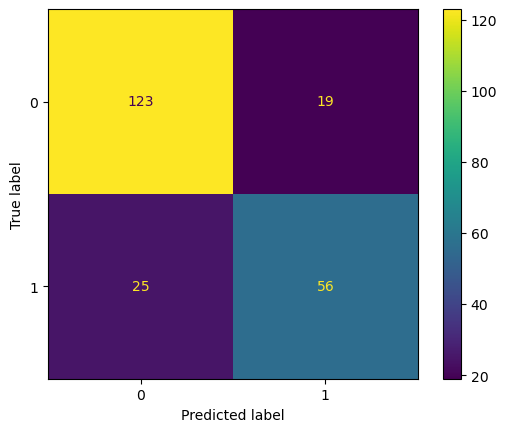

In [20]:
cm.plot()

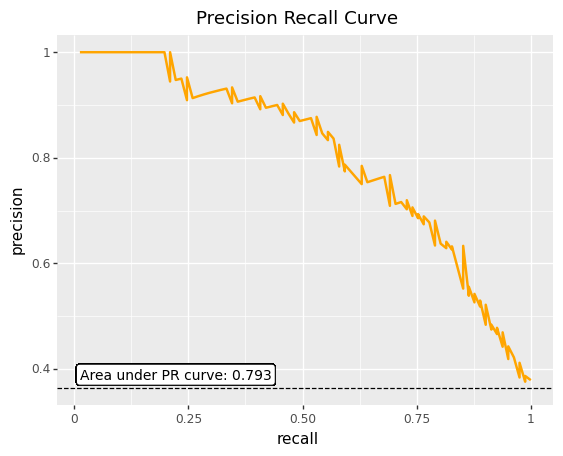

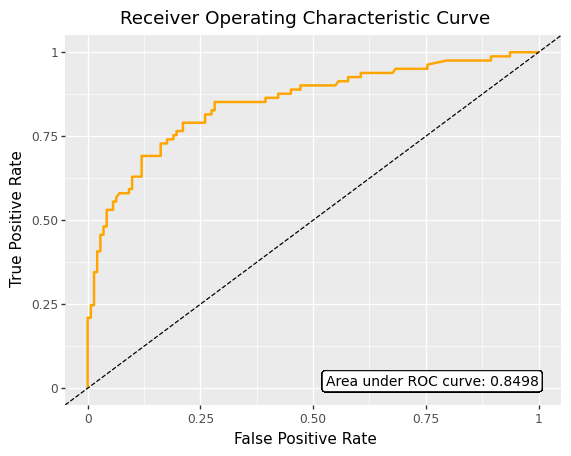

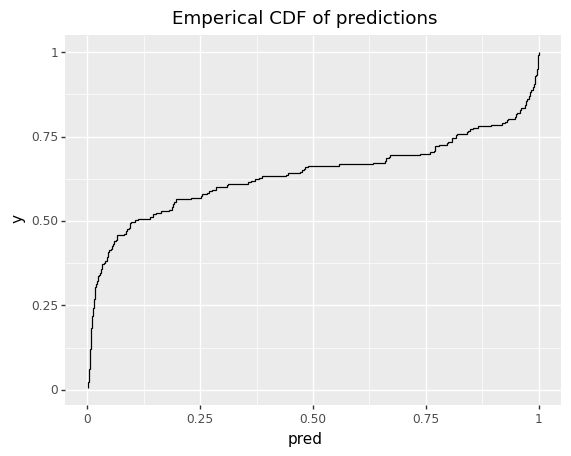

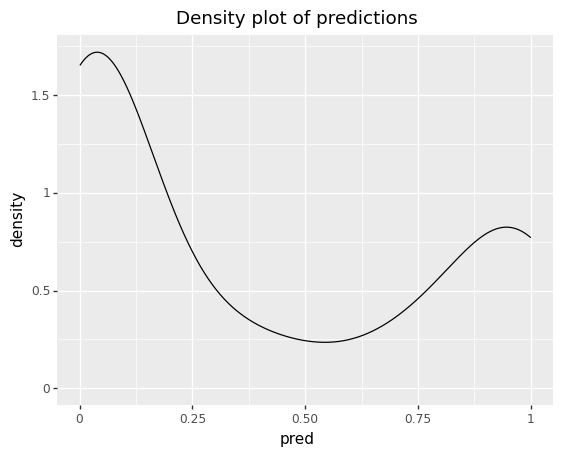

[<ggplot: (8769845899581)>,
 <ggplot: (8769845906152)>,
 <ggplot: (8769845988337)>,
 <ggplot: (8769845990132)>]

In [21]:
plots_list

# Try a Logistic Regression

In [22]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

lr = LogisticRegression()

ct = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols),
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
])

imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

pipe = Pipeline([
    ('feature engineering', ct),
    ('impute_nas', imputer),
    ('clf', lr)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('feature engineering',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('impute_nas', SimpleImputer()),
                ('clf', LogisticRegression())])

In [23]:
preds = pipe.predict_proba(X_test)[:,1]
preds_binary = pipe.predict(X_test)

scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)

In [24]:
scores_list[0]

{'accuracy': 0.8026905829596412,
 'average_precision': 0.7927192018114588,
 'f1_score': 0.717948717948718}

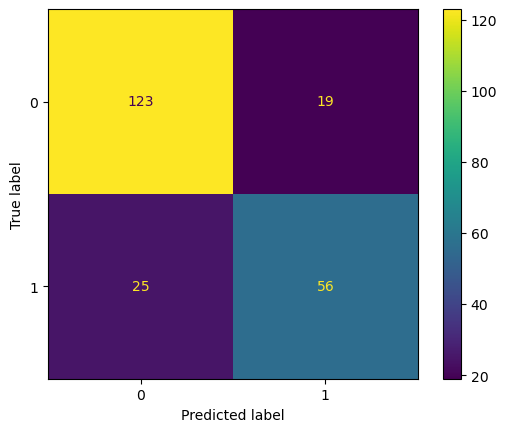

In [25]:
cm.plot()

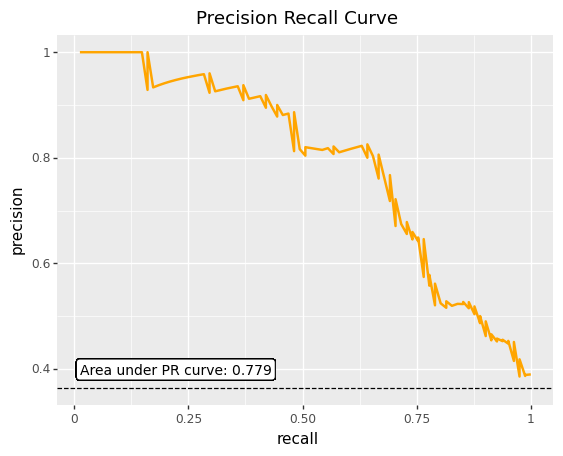

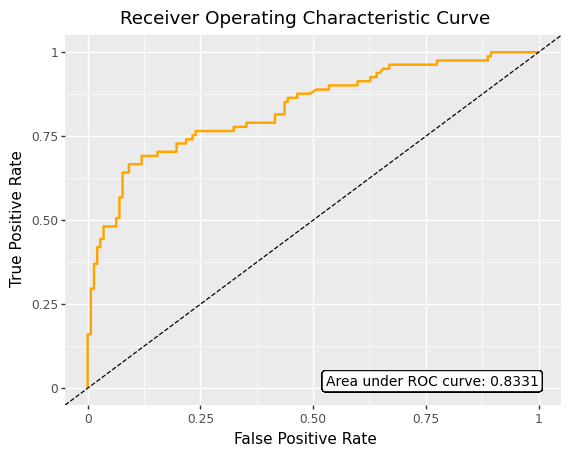

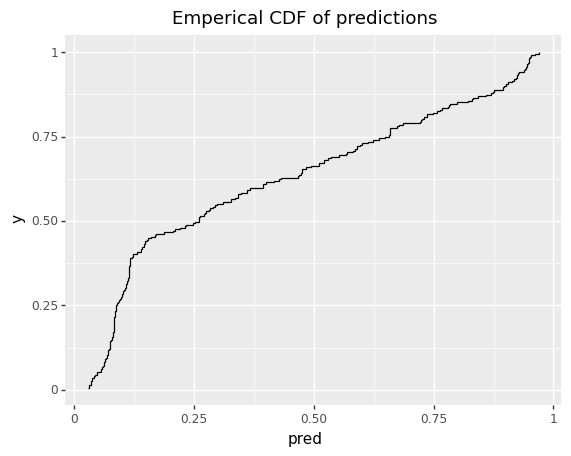

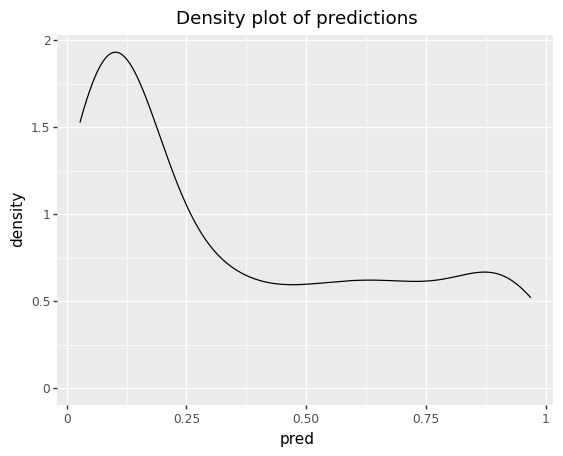

[<ggplot: (8769845036057)>,
 <ggplot: (8769845048667)>,
 <ggplot: (8769878297956)>,
 <ggplot: (8769846744564)>]

In [26]:
plots_list